**Exercise 9.6.1**.  Consider the data in example 9.6.  

- Find the plug-in estimate of the correlation coefficient.  
- Estimate the standard error using the bootstrap.  
- Find a 95% confidence interval using all three methods.

In [1]:
# Data from example 9.6:

LSAT = [576, 635, 558, 578, 666, 580, 555, 661, 651, 605, 653, 575, 545, 572, 594]
GPA = [3.39, 3.30, 2.81, 3.03, 3.44, 3.07, 3.00, 3.43, 3.36, 3.13, 3.12, 2.74, 2.76, 2.88, 3.96]

<AxesSubplot:xlabel='LSAT', ylabel='GPA'>

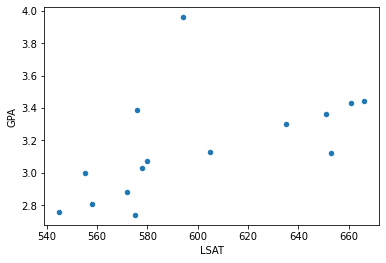

In [18]:
import math
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot
%matplotlib inline

df=pd.DataFrame({'LSAT': LSAT, 'GPA': GPA})
df.plot.scatter(x='LSAT',y='GPA')

In [24]:
# plug in estimate for correlation
X=df['LSAT'].to_numpy()
Y=df['GPA'].to_numpy()

def corr(X, Y):
    mu_x=X.mean()
    mu_y=Y.mean()
    return sum((X-mu_x)*(Y-mu_y)) / math.sqrt(sum((X-mu_x)**2)*sum((Y-mu_y)**2))

theta_hat=corr(X,Y)

print('calculated correlation: %.4f' %corr(X, Y))

from scipy.stats import pearsonr
pearson, _ =pearsonr(X,Y)
print('scipy stats pearson correlation: %.4f' %pearson)

calculated correlation: 0.5459
scipy stats pearson correlation: 0.5459


In [25]:
# bootstrap for se of correlation
nx=len(X)
ny=len(Y)
B=1000000
t_boot=np.empty(B)
for i in tqdm(range(B)):
    xx=np.random.choice(X, nx, replace=True)
    yy=np.random.choice(Y, ny, replace=True)
    t_boot[i]=corr(xx, yy)
    
se=t_boot.std()
print('estimated se of correlation: %.4f' % se)


estimated se of correlation: 0.2670


In [26]:
# CI from 3 methods
from scipy.stats import norm

z=norm.ppf(.975)

normal_ci=(theta_hat-z*se, theta_hat+z*se)
percentile_ci=(np.quantile(t_boot, 0.025), np.quantile(t_boot, 0.975))
pivot_ci=(2*theta_hat-np.quantile(t_boot,0.975), 2*theta_hat-np.quantile(t_boot, 0.025))

print('95%% normal CI: \t %.3f, %.3f' % normal_ci)
print('95%% percentile CI: \t %.3f, %.3f' % percentile_ci)
print('95%% pivotal CI: \t %.3f, %.3f' % pivot_ci)

95% normal CI: 	 0.023, 1.069
95% percentile CI: 	 -0.501, 0.523
95% pivotal CI: 	 0.569, 1.593


**Exercise 9.6.2**.  (Computer Experiment).  Conduct a simulation to compare the four bootstrap confidence interval methods.

Let $n = 50$ and let $T(F) = \int (x - \mu)^3 dF(x) / \sigma^3$ be the skewness.  Draw $Y_1, \dots, Y_n \sim N(0, 1)$ and set $X_i = e^{Y_i}$, $i = 1, \dots, n$.  Construct the four types of bootstrap 95% intervals for $T(F)$ from the data $X_1, \dots, X_n$.  Repeat this whole thing many times and estimate the true coverage of the four intervals.

In [68]:
import numpy as np
from tqdm.notebook import tqdm
from scipy.stats import norm

def create_data(n):
    y=norm.rvs(size=n)
    return np.exp(y)

def skewness(x):
    n=len(x)
    mu=x.mean()
    sd=x.std()
    #var=sum((x-mu)**2)/n
    return sum((x-mu)**3)/(n*sd**3)
    #return sum((x-mu)**3/(n*var**(3/2)))

def bootstrap(x, B, show_progress=True):
    n=len(x)
    t_boot=np.empty(B)
    iterable=tqdm(range(B)) if show_progress else range(B)
    for i in iterable:
        xx=np.random.choice(x,n,replace=True)
        t_boot[i]=skewness(xx)
    return t_boot

def bootstrap_intervals(theta_hat, t_boot, alpha):
    se=t_boot.std()
    z=norm.ppf(1-alpha/2)
    q_l=np.quantile(t_boot, alpha/2)
    q_u=np.quantile(t_boot, 1-alpha/2)
    
    normal_ci=(theta_hat-z*se, theta_hat+z*se)
    perc_ci=(q_l, q_u)
    pivot_ci=(2*theta_hat-q_u, 2*theta_hat-q_l)
    
    return normal_ci, perc_ci, pivot_ci

In [73]:
#creating dataset
x=create_data(n=200)

#nonparametric bootstrap
theta_hat=skewness(x)
t_boot=bootstrap(x, B=100000)

normal, perc, pivot=bootstrap_intervals(theta_hat, t_boot, alpha=0.05)

print('skewness: \t %.3f' %theta_hat)
print('95%% normal ci: \t %.3f, %.3f' %normal)
print('95%% percentile ci: \t %.3f, %.3f' %perc)
print('95%% pivotal ci: \t %.3f, %.3f' %pivot)


skewness: 	 2.771
95% normal ci: 	 1.981, 3.561
95% percentile ci: 	 1.852, 3.449
95% pivotal ci: 	 2.093, 3.691


In [65]:
#parametric bootstrap

log_x=np.log(x.mean())
log_x2=np.log((x**2).mean())
mu=4*log_x-log_x2
sigma=np.sqrt(log_x2-2*log_x)

B=10000
n=len(x)
t_boot=np.empty(B)
for i in tqdm(range(B)):
    xx=np.exp(norm.rvs(size=n, loc=mu, scale=sigma))
    t_boot[i]=skewness(xx)
    
se=t_boot.std()

print('mu, sigma: %.3f, %.3f' % (mu, sigma))

z=norm.ppf(.975)
param_ci=(theta_hat-z*se, theta_hat+z*se)
print('95%% parametric ci: \t %.3f, %.3f' % param_ci)


mu, sigma: -0.572, 1.250
95% parametric ci: 	 4.225, 10.475


In [75]:
# repeat nn=10 times

nn=100

true_skewness=(np.exp(1)+2)*np.sqrt(np.exp(1)-1)
coverage_normalCI=[]
coverage_percentileCI=[]
coverage_pivotalCI=[]
for i in tqdm(range(nn)):
    theta_hat=skewness(x)
    t_boot_nn=bootstrap(x, B=10000, show_progress=False)
    norm_ci, perc_ci, pivot_ci=bootstrap_intervals(theta_hat, t_boot_nn, alpha=.05)
    coverage_normalCI.append((norm_ci[1]>=true_skewness) & (true_skewness>=norm_ci[0]))
    coverage_percentileCI.append((perc_ci[1]>=true_skewness) & (true_skewness>=perc_ci[0]))
    coverage_pivotalCI.append((pivot_ci[1]>=true_skewness) & (true_skewness>=pivot_ci[0]))
    
    
print('Coverage of normal CI: %.3f' %np.array(coverage_normalCI).mean())
print('Coverage of percentile CI: %.3f' %np.array(coverage_percentileCI).mean())
print('Coverage of pivotal CI: %.3f' %np.array(coverage_pivotalCI).mean())



Coverage of normal CI: 0.000
Coverage of percentile CI: 0.000
Coverage of pivotal CI: 0.000


**Exercise 9.6.3**.  Let  $X_1, \dots, X_n \sim t_3$ where $n = 25$.  Let $\theta = T(F) = (q_{.75} - q_{.25})/1.34$ where $q_p$ denotes the $p$-th quantile.  Do a simulation to compare the coverage and length of the following confidence intervals for $\theta$:

- Normal interval with standard error from the bootstrap
- Bootstrap percentile interval

Remark: the jacknife does not give a consistent estimator of the variance of a quantile.

In [76]:
import numpy as np
from scipy.stats import t
from tqdm.notebook import tqdm

n=25
X=t.rvs(3, size=n)

def T(x):
    return (np.quantile(x, 0.75)-np.quantile(x,0.25)) / 1.34

In [77]:
theta_hat=T(X)

In [79]:
# Run bootstrap
B=100000
t_boot=np.empty(B)
for i in tqdm(range(B)):
    xx=np.random.choice(X, n, replace=True)
    t_boot[i]=T(xx)
    
se_boot=t_boot.std()

z=norm.ppf(.975)
normal_ci=(theta_hat-z*se_boot, theta_hat+z*se_boot)
perc_ci=(np.quantile(t_boot,0.025), np.quantile(t_boot, 0.975))

print('95%% normal CI: \t %.3f, %.3f' %normal_ci)
print('95%% perc CI: \t %.3f, %.3f' %perc_ci)


95% normal CI: 	 -0.461, 1.844
95% perc CI: 	 0.351, 2.267


In [ ]:
#jacknife

def jacknife_se(x):
    n=len(x)
    t_i=np.empty(n)
    for i in range(n):
        t_i[i]=T(np.delete(x, i))
    return t_i.std()*np.sqrt((n-1)/n)

nn=np.arange(10000)
se=np.empty(10000)
for i in tqdm(nn):
    X=t.rvs(3, size=i+2)
    se[i]=jacknife_se(X)

import matplotlib.pyplot as plt

plt.plot(nn, se)
    

**(a)** $$
\begin{align}
\mathbb{E}(\overline{X}_n^* | X_1, \dots, X_n) &= \mathbb{E}\left(n^{-1}\sum_{i=1}^nX_i\right) = n^{-1}\sum_{i=1}^n \mathbb{E}(X_i) = \mathbb{E}(X)
\end{align}
$$